In [1]:
import transformers
from transformers import BertTokenizer

import torch
from transformers import BertModel
from transformers.modeling_outputs import SequenceClassifierOutput
from torch.nn import  CrossEntropyLoss
import torch.nn as nn
from transformers import BertForSequenceClassification, AdamW, BertConfig

In [2]:
class SARCBertClassifier(BertForSequenceClassification):
    """
    Classifier to handle classification task on SARC dataset
    """
    def __init__(self,config):
        super(SARCBertClassifier, self).__init__(config)
#         self.mlp_layer=None
#         self.prefix_embeddings =None
        self.run_device = None
    def update_network_sarc(self,num_layers,device,freeze_bert_layers=False,custom_embedding=False,custom_embedding_vector=None,add_user_information=False):
        """
        Update the network architecture all the variable are class variables from source code of BerforSequenceClassification
        transformer module
        """
        config=self.config
        if(freeze_bert_layers):
            for name,param in self.bert.named_parameters():
                if(name!="embeddings.prefix_embeddings.weight"):
                    param.requires_grad = False
        self.prefix_embeddings = nn.Embedding(config.prefix_length, config.hidden_size)
        self.prefix_length = config.prefix_length
        self.mlp_layer = nn.Sequential(nn.Linear(config.hidden_size, config.hidden_size),
                nn.Tanh(),
                nn.Linear(config.hidden_size,config.hidden_size))
        
        if(add_user_information):
            self.classifier = nn.Linear(config.hidden_size+2, config.num_labels)
        
        if(custom_embedding):
            self.prefix_length = config.prefix_length
            self.mlp_layer = nn.Sequential(nn.Linear(config.hidden_size, config.hidden_size),
                    nn.Tanh(),
                    nn.Linear(config.hidden_size,config.hidden_size))

            self.init_weights()
            
            custom_embedding_vector = custom_embedding_vector.expand(config.prefix_length,custom_embedding_vector.shape[0])
            self.prefix_embeddings=nn.Embedding.from_pretrained(custom_embedding_vector)
        else:
            self.prefix_embeddings = nn.Embedding(config.prefix_length, config.hidden_size)
            self.prefix_length = config.prefix_length
            self.mlp_layer = nn.Sequential(nn.Linear(config.hidden_size, config.hidden_size),
                    nn.Tanh(),
                    nn.Linear(config.hidden_size,config.hidden_size))
            self.init_weights()
        self.run_device = device
    
    def check_closest_matching_bert_model(self):
        prefix_tokens = self.prefix_embeddings(torch.LongTensor(torch.arange(1)).to(self.run_device)).detach()
        bert_base = self.bert.embeddings.word_embeddings(torch.LongTensor(torch.arange(30522)).to(self.run_device)).detach()
        closest_words_ids = [] 
        for embd in prefix_tokens:
            closest_words_ids.append(torch.norm(bert_base - embd.unsqueeze(0), dim=1).topk(5).indices)
        tokenizer = BertTokenizer.from_pretrained("./prefix_tuning_model_random_initializations_prefix_tuninglr_2e-5/")
        closest_words_ids=torch.stack(closest_words_ids)
        closest = {}
        for idx,t in enumerate(closest_words_ids):
            word_l = []
            for tok in t:
                word_l.append(tokenizer._convert_id_to_token(int(tok)))
            closest[idx]=word_l
        return closest
    
    def closest_matching_bert_model(self):
        prefix_tokens = self.prefix_embeddings(torch.LongTensor(torch.arange(self.prefix_embeddings.weight.shape[0])).to(self.run_device)).detach()
        bert_base = self.bert.embeddings.word_embeddings(torch.LongTensor(torch.arange(30522)).to(self.run_device)).detach()
        closest_words_ids = [] 
        for embd in prefix_tokens:
            closest_words_ids.append(torch.norm(bert_base - embd.unsqueeze(0), dim=1).topk(5).indices)
        tokenizer = BertTokenizer.from_pretrained("./prefix_tuning_model_random_initializations_prefix_tuninglr_2e-5/")
        closest_words_ids=torch.stack(closest_words_ids)
        closest = {}
        for idx,t in enumerate(closest_words_ids):
            word_l = []
            for tok in t:
                word_l.append(tokenizer._convert_id_to_token(int(tok)))
            closest[idx]=word_l
        return closest
    
    def forward(self,input_ids=None,attention_mask=None,token_type_ids=None,position_ids=None,
        head_mask=None,inputs_embeds=None,labels=None,output_attentions=None,output_hidden_states=None,return_dict=None,
                user_information=False):
        r"""

        FROM CORE HUGGINGFACE MODULE 
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the sequence classification/regression loss. Indices should be in :obj:`[0, ...,
            config.num_labels - 1]`. If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        prefix_embds = self.prefix_embeddings(torch.arange(0, self.prefix_length).to(self.run_device))
        prefix_embds = self.mlp_layer(prefix_embds)
        prefix_embds = prefix_embds.expand(len(input_ids),prefix_embds.shape[0],prefix_embds.shape[1])
        attention_mask = torch.cat((torch.ones(self.prefix_length).to(self.run_device).expand(attention_mask.shape[0],self.prefix_length),attention_mask),1)
        
#         if(user_information):
#             attention_mask = attention_mask[:,2:] 
#             user_ids =  input_ids[:,:2]
#             input_ids = input_ids[:,2:].to(self.run_device).long()
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            prefix_embeddings=prefix_embds,
        )

        pooled_output = outputs[1]
        
        pooled_output = self.dropout(pooled_output)
        
#         if(user_information):
#             pooled_output = torch.cat((user_ids,pooled_output),dim=1)
        
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [2]:
#Custom Embeddings
from transformers import BertTokenizer,BertModel
import torch
def get_bert_embedding(word):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    tokenized_res = tokenizer.encode_plus(
                            word,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 5,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )
    embed_model = BertModel.from_pretrained('bert-base-uncased')
    embed_model.eval()
    embedding = embed_model(**tokenized_res)
    embedding = embedding.last_hidden_state.detach()#[:,tokenized_res['attention_mask']]    
    required_embedding = embedding[0][tokenized_res['attention_mask'][0]==1,:]
    required_embedding = required_embedding.mean(dim=0)
    del embed_model
    del embedding 
    return required_embedding



In [ ]:
custom_embedding = get_bert_embedding("sarcasm detection")

In [ ]:
custom_embedding

In [3]:
config = BertConfig.from_pretrained("bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 2, # The number of output labels--2 for binary classification.
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
        )
# config.prefix_length = 5

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
# model = SARCBertClassifier(config)

# model.update_network_sarc(2,device,freeze_bert_layers=True)

# # model = nn.DataParallel(model)
# model.to(device)
# model.cuda()

# for n,p in model.named_parameters():
#     if p.requires_grad:
#         print(n)
device = "cuda:0"


There are 2 GPU(s) available.


In [4]:
prefix_include = False
experiment = "noprefix_bottomtwo_layers"

In [7]:
if(prefix_include):
    model = SARCBertClassifier(config)

    model.update_network_sarc(2,device,freeze_bert_layers=True)#,custom_embedding=True,custom_embedding_vector=custom_embedding)
    
else:
    model = BertForSequenceClassification(config)

model.to(device)

for n,p in model.named_parameters():
    if(experiment == "noprefix_toptwo_layers"):
        if("bert.encoder.layer.10." in n or "bert.encoder.layer.11." in n or n=="classifier.weight"):
            p.requires_grad = True
        else:
            p.requires_grad = False
        if p.requires_grad:
            print("Tuning:",n)
    if(experiment == "noprefix_bottomtwo_layers"):
        if("bert.encoder.layer.0." in n or "bert.encoder.layer.1." in n or n=="classifier.weight"):
            p.requires_grad = True
        else:
            p.requires_grad = False
        if p.requires_grad:
            print("Tuning:",n)

Tuning: bert.encoder.layer.0.attention.self.query.weight
Tuning: bert.encoder.layer.0.attention.self.query.bias
Tuning: bert.encoder.layer.0.attention.self.key.weight
Tuning: bert.encoder.layer.0.attention.self.key.bias
Tuning: bert.encoder.layer.0.attention.self.value.weight
Tuning: bert.encoder.layer.0.attention.self.value.bias
Tuning: bert.encoder.layer.0.attention.output.dense.weight
Tuning: bert.encoder.layer.0.attention.output.dense.bias
Tuning: bert.encoder.layer.0.attention.output.LayerNorm.weight
Tuning: bert.encoder.layer.0.attention.output.LayerNorm.bias
Tuning: bert.encoder.layer.0.intermediate.dense.weight
Tuning: bert.encoder.layer.0.intermediate.dense.bias
Tuning: bert.encoder.layer.0.output.dense.weight
Tuning: bert.encoder.layer.0.output.dense.bias
Tuning: bert.encoder.layer.0.output.LayerNorm.weight
Tuning: bert.encoder.layer.0.output.LayerNorm.bias
Tuning: bert.encoder.layer.1.attention.self.query.weight
Tuning: bert.encoder.layer.1.attention.self.query.bias
Tuning: 

In [ ]:
# batch = next(iter(dataloader_train))
yhat = model(b_input_ids,b_input_mask)

In [ ]:
from torchviz import make_dot
make_dot(yhat['logits'], params=dict(list(model.named_parameters()))).render("bert_graph", format="png")

In [10]:
import numpy as np 
import pandas as pd 
import torch
from transformers import BertTokenizer

import numpy as np
import multiprocessing as mp
import time

from tqdm import tqdm


def parallelize(function_pointer,list_to_parallelize,NUM_CORE=2*mp.cpu_count()):
    '''
    Prallel apply the given function to the list the numeber of process will 
    be twice the number of cpu cores by default 
    '''
    start=time.time()
    component_list=np.array_split(list_to_parallelize,NUM_CORE*10)
    pool = mp.Pool(NUM_CORE)
    results = pool.map(function_pointer,component_list)
    pool.close()
    pool.join()
    end=time.time()
    print("Executed in:",end-start)
    return results


import pickle
# f = open('processed_data.pckl', 'wb')
# pickle.dump([input_ids,attention_masks,labels], f)
# f.close()

f = open('processed_data.pckl', 'rb')
test = pickle.load(f)
f.close()


input_ids = test[0]
attention_masks = test[1]
labels = test[2]



from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))


from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 64

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size, # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size, # Evaluate with this batch size.
            )


# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


import numpy as np
import time
import datetime

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)



def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats_custom = []

# Measure the total training time for the whole run.
# total_t0 = time.time()
import json
import os
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    
    total_training_loss = 0
    total_correct_predictions, total_predictions = 0, 0
    generator_tqdm = tqdm(train_dataloader)
    output_dir = './NO_prefix_tuning_with_unfreezed_bottom_2_layers_random_intialization/'

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    elif(epoch_i==0):
        print("directory exists")
        raise Exception('My error!')

    print("Saving model to %s" % output_dir)
    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(output_dir)
    
    
    
#     with open(output_dir+"prefix_embed_matching_words_epoch_"+str(epoch_i)+".json", 'w') as fp:
#         json.dump(model.closest_matching_bert_model(), fp)
    # For each batch of training data...
    for step, batch in enumerate(generator_tqdm):

        # Progress update every 40 batches.
        if(not prefix_include):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
        else:
            b_input_ids = torch.cat((torch.arange(0, config.prefix_length).expand(batch[0].shape[0], config.prefix_length),batch[0]),1).to(device)
            b_input_mask = torch.cat((torch.ones(config.prefix_length).expand(batch[1].shape[0], config.prefix_length),batch[1]),1).to(device)
        
        b_labels = batch[2].to(device)
        
        model.zero_grad()        
#         optimizer.zero_grad()
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.mean()

        # Perform a backward pass to calculate the gradients.
        loss.mean().backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
        
#         batch_predictions = np.argmax(nn.Softmax(dim=1)(logits).detach().cpu().numpy(), axis=-1)
#         total_correct_predictions += (batch_predictions == b_labels.detach().cpu().numpy()).sum()
#         total_predictions += b_labels.shape[0]
            
        description = ("Average training loss: %.2f" % (total_train_loss/(step+1)))
        generator_tqdm.set_description(description, refresh=False)
        
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    print("Evaluation In Progress")
    # Evaluate data for one epoch
    
    for batch in tqdm(validation_dataloader):
        if(prefix_include):
            b_input_ids = torch.cat((torch.arange(0, config.prefix_length).expand(batch[0].shape[0], config.prefix_length),batch[0]),1).to(device)

            b_input_mask = torch.cat((torch.ones(config.prefix_length).expand(batch[1].shape[0], config.prefix_length),batch[1]),1).to(device)
        else:
            b_input_ids=batch[0].to(device)
            b_input_mask=batch[1].to(device) 
        b_labels = batch[2].to(device)
        
        
        with torch.no_grad():
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.mean()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats_custom.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

818,723 training samples
90,970 validation samples

======== Epoch 1 / 4 ========
Training...


  0%|          | 0/12793 [00:00<?, ?it/s]

Saving model to ./NO_prefix_tuning_with_unfreezed_bottom_2_layers_random_intialization/


Average training loss: 0.58: 100%|██████████| 12793/12793 [55:27<00:00,  3.84it/s]



  Average training loss: 0.58
  Training epcoh took: 0:55:28

Running Validation...
Evaluation In Progress


100%|██████████| 1422/1422 [02:50<00:00,  8.32it/s]


  Accuracy: 0.71
  Validation Loss: 0.56
  Validation took: 0:02:51

======== Epoch 2 / 4 ========
Training...


  0%|          | 0/12793 [00:00<?, ?it/s]

Saving model to ./NO_prefix_tuning_with_unfreezed_bottom_2_layers_random_intialization/


Average training loss: 0.55: 100%|██████████| 12793/12793 [55:24<00:00,  3.85it/s]



  Average training loss: 0.55
  Training epcoh took: 0:55:25

Running Validation...
Evaluation In Progress


100%|██████████| 1422/1422 [02:50<00:00,  8.32it/s]


  Accuracy: 0.72
  Validation Loss: 0.55
  Validation took: 0:02:51

======== Epoch 3 / 4 ========
Training...


  0%|          | 0/12793 [00:00<?, ?it/s]

Saving model to ./NO_prefix_tuning_with_unfreezed_bottom_2_layers_random_intialization/


Average training loss: 0.53:  45%|████▌     | 5802/12793 [25:10<30:19,  3.84it/s]


KeyboardInterrupt: 

In [10]:
training_stats_custom

[{'epoch': 1,
  'Training Loss': tensor(0.6084, device='cuda:0', grad_fn=<DivBackward0>),
  'Valid. Loss': tensor(0.5761, device='cuda:0'),
  'Valid. Accur.': 0.6918512658227848,
  'Training Time': '0:34:47',
  'Validation Time': '4:25:36'},
 {'epoch': 2,
  'Training Loss': tensor(0.5818, device='cuda:0', grad_fn=<DivBackward0>),
  'Valid. Loss': tensor(0.5691, device='cuda:0'),
  'Valid. Accur.': 0.7037335686465434,
  'Training Time': '0:34:42',
  'Validation Time': '0:02:51'},
 {'epoch': 3,
  'Training Loss': tensor(0.5691, device='cuda:0', grad_fn=<DivBackward0>),
  'Valid. Loss': tensor(0.5574, device='cuda:0'),
  'Valid. Accur.': 0.711689758465866,
  'Training Time': '0:34:44',
  'Validation Time': '0:02:51'},
 {'epoch': 4,
  'Training Loss': tensor(0.5602, device='cuda:0', grad_fn=<DivBackward0>),
  'Valid. Loss': tensor(0.5556, device='cuda:0'),
  'Valid. Accur.': 0.7143590081683436,
  'Training Time': '0:34:46',
  'Validation Time': '0:02:51'}]

In [ ]:
model.prefix_embeddings(torch.Tensor(1).long().to(device))

In [ ]:
model.prefix_embeddings.

In [ ]:
torch.cat((torch.ones(5).expand(128, 5),batch[1]),1).shape

In [ ]:
torch.arange(0., 5).expand(128, 5)

In [ ]:
tt=torch.cat((torch.arange(0., 5).expand(128, 5),batch[0]),1)

In [ ]:
batch[0].shape

In [ ]:
for b in generator_tqdm:#
    print(b[2])
    break

In [ ]:
model.bert.get_parameter('embeddings.prefix_embeddings.weight')

# OLD

In [ ]:
import numpy as np 
import pandas as pd 
import torch
from transformers import BertTokenizer

import numpy as np
import multiprocessing as mp
import time

from tqdm import tqdm


def parallelize(function_pointer,list_to_parallelize,NUM_CORE=2*mp.cpu_count()):
    '''
    Prallel apply the given function to the list the numeber of process will 
    be twice the number of cpu cores by default 
    '''
    start=time.time()
    component_list=np.array_split(list_to_parallelize,NUM_CORE*10)
    pool = mp.Pool(NUM_CORE)
    results = pool.map(function_pointer,component_list)
    pool.close()
    pool.join()
    end=time.time()
    print("Executed in:",end-start)
    return results

In [ ]:
# data = pd.read_csv("train-balanced-sarcasm.csv")

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
training_set,test_set = train_test_split(data,stratify=data[["label"]], test_size=0.1)

In [ ]:
test_set.to_csv("test_set.csv",index=False)

In [ ]:
del data

In [ ]:
training_set.dropna(subset=["comment"],inplace=True)

training_set.reset_index(drop=False,inplace=True)

training_set.rename(columns={"index":"id"},inplace=True)
sentences = training_set[["id","comment"]]
labels = training_set[["id","label"]]

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
def tokenize(sentences):
    max_len = 0
    for _,row in sentences.iterrows():
        sent=row["comment"]
        try:
            input_ids = tokenizer.encode(sent, add_special_tokens=True)
        except:
            input_ids = tokenizer.encode("", add_special_tokens=True)
        max_len = max(max_len, len(input_ids))
    return max_len

In [ ]:
max_len = max(parallelize(tokenize,sentences))
# tokenize(sentences)

In [ ]:
sentences=training_set.comment.values
labels = training_set.label.values


# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in tqdm(sentences):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

In [ ]:
import pickle
# f = open('processed_data.pckl', 'wb')
# pickle.dump([input_ids,attention_masks,labels], f)
# f.close()

In [ ]:
f = open('processed_data.pckl', 'rb')
test = pickle.load(f)
f.close()

In [ ]:
input_ids = test[0]
attention_masks = test[1]
labels = test[2]

In [ ]:
input_ids

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 128

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size, # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size, # Evaluate with this batch size.
            )

In [ ]:
for i in validation_dataloader:
    print(len(i))
    print(i[0].shape)
    break

In [ ]:
from transformers import BertModel
from transformers.modeling_outputs import SequenceClassifierOutput
from torch.nn import  CrossEntropyLoss
import torch.nn as nn
from transformers import BertForSequenceClassification, AdamW, BertConfig

class SARCBertClassifier(BertForSequenceClassification):
    """
    Classifier to handle classification task on SARC dataset
    """
    def __init__(self,config):
        super(SARCBertClassifier, self).__init__(config)
        
    def update_network_sarc(self,num_layers,device,freeze_bert_layers=False,training_mode="PrefixTuning",sequence_length=3,embedding_dimension=1024):
        """
        Update the network architecture all the variable are class variables from source code of BerforSequenceClassification
        transformer module
        """
        config=self.config
        if(freeze_bert_layers):
            for param in self.bert.parameters():
                param.requires_grad = False
        self.training_mode = training_mode
        if(self.training_mode=="PrefixTuning"):
            self.prefix_layer = nn.Embedding(sequence_length,embedding_dimension)
    
        self.classifier = nn.Sequential()
        for layer in range(num_layers-1):
            self.classifier.add_module("classification_layer_"+str(layer+1),nn.Linear(config.hidden_size, config.hidden_size))
            self.classifier.add_module("activation_layer_"+str(layer+1),nn.ReLU())    
        
        self.classifier.add_module("output_layer",nn.Linear(config.hidden_size, config.num_labels))
        self.classifier.to(device)
        self.init_weights()
        
    def forward(self,input_ids=None,attention_mask=None,token_type_ids=None,position_ids=None,
        head_mask=None,inputs_embeds=None,labels=None,output_attentions=None,output_hidden_states=None,return_dict=None,):
        r"""

        FROM CORE HUGGINGFACE MODULE 
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the sequence classification/regression loss. Indices should be in :obj:`[0, ...,
            config.num_labels - 1]`. If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
custom=True
if custom:
    model = SARCBertClassifier.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 2, # The number of output labels--2 for binary classification.
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    model.update_network_sarc(2,device,freeze_bert_layers=True)
else:
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 2, # The number of output labels--2 for binary classification. 
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

In [ ]:
import torch.nn as nn
model = nn.DataParallel(model)
model.to(device)
model.cuda()

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 0.05, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
float(2e-5)

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np
import time
import datetime

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)



def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats_custom = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    
    total_training_loss = 0
    total_correct_predictions, total_predictions = 0, 0
    generator_tqdm = tqdm(train_dataloader)
        
    # For each batch of training data...
    for step, batch in enumerate(generator_tqdm):

        # Progress update every 40 batches.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        model.zero_grad()        
#         optimizer.zero_grad()
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.mean()

        # Perform a backward pass to calculate the gradients.
        loss.mean().backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
        
        batch_predictions = np.argmax(nn.Softmax(dim=1)(logits).detach().cpu().numpy(), axis=-1)
        total_correct_predictions += (batch_predictions == b_labels.detach().cpu().numpy()).sum()
        total_predictions += b_labels.shape[0]
            
        description = ("Average training loss: %.2f Accuracy: %.2f  Lable sum: %2f"
                           % (total_train_loss/(step+1), total_correct_predictions/total_predictions,batch_predictions.sum()))
        generator_tqdm.set_description(description, refresh=False)

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    print("Evaluation In Progress")
    # Evaluate data for one epoch
    
    for batch in tqdm(validation_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.mean()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats_custom.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
training_stats = training_stats_custom
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
# df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2,3,4])

plt.show()

In [11]:
tokenizer = BertTokenizer.from_pretrained('./prefix_tuning_model_random_initializations/')


In [12]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './NO_prefix_tuning_with_unfreezed_bottom_2_layers_random_intialization/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./NO_prefix_tuning_with_unfreezed_bottom_2_layers_random_intialization/


('./NO_prefix_tuning_with_unfreezed_bottom_2_layers_random_intialization/tokenizer_config.json',
 './NO_prefix_tuning_with_unfreezed_bottom_2_layers_random_intialization/special_tokens_map.json',
 './NO_prefix_tuning_with_unfreezed_bottom_2_layers_random_intialization/vocab.txt',
 './NO_prefix_tuning_with_unfreezed_bottom_2_layers_random_intialization/added_tokens.json')

# Testing

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
output_dir = './prefix_tuning_with_unfreezed_embedding_layer/'


config = BertConfig.from_pretrained(output_dir,)
config.user_embeddings=True

model = SARCBertClassifier.from_pretrained(output_dir)
# tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
# model.to(device)

In [13]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("test_set.csv")

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

Number of test sentences: 101,083



In [14]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [15]:
# Create sentence and label lists
sentences = df.dropna(subset=["comment"]).comment.values
labels = df.dropna(subset=["comment"]).label.values

In [16]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

Token indices sequence length is longer than the specified maximum sequence length for this model (580 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
!pip3 install keras

In [17]:
from tqdm import tqdm
import torch

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [18]:
# Pad our input tokens
from keras.preprocessing.sequence import pad_sequences
input_ids = pad_sequences(input_ids, maxlen=64, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in tqdm(input_ids):
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

100%|██████████| 101080/101080 [00:04<00:00, 22753.50it/s]


In [ ]:
device

In [19]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in tqdm(prediction_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    if(prefix_include):
        b_input_ids = torch.cat((torch.arange(0, 5).expand(b_input_ids.shape[0], 5).to(device),b_input_ids),1).to(device)
        b_input_mask = torch.cat((torch.ones(5).expand(b_input_mask.shape[0], 5).to(device),b_input_mask),1).to(device)
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

    logits = outputs.logits#outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('DONE.')

Predicting labels for 101,080 test sentences...


100%|██████████| 3159/3159 [03:15<00:00, 16.16it/s]

DONE.


In [29]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

14177280

In [20]:
true_labels[0]

array([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0])

In [21]:
predictions[5]

array([[-0.82481015,  1.2320392 ],
       [-1.6283038 ,  1.9350392 ],
       [-0.36508894,  0.7768754 ],
       [ 0.5367286 , -0.3059828 ],
       [ 0.9837166 , -0.8803557 ],
       [ 0.6849129 , -0.46184498],
       [ 0.4050085 , -0.1421056 ],
       [ 0.8203619 , -0.65921706],
       [ 0.06800893,  0.29526252],
       [-1.3281451 ,  1.6307966 ],
       [ 0.37128958, -0.05452841],
       [ 0.5075836 , -0.26008534],
       [ 0.64459616, -0.38483444],
       [ 0.7153135 , -0.48924652],
       [-0.04507451,  0.43352556],
       [ 0.6061663 , -0.35672152],
       [ 0.35888046, -0.0669265 ],
       [-0.3528226 ,  0.7524141 ],
       [-0.46195805,  0.84969926],
       [ 1.1890585 , -1.2155231 ],
       [-0.3090629 ,  0.8012265 ],
       [ 0.8838628 , -0.7491174 ],
       [-0.7050549 ,  1.0997629 ],
       [ 0.26810032,  0.03972005],
       [-2.1440077 ,  2.3286133 ],
       [ 0.22543845,  0.11010227],
       [ 0.7372776 , -0.5644066 ],
       [ 0.69390297, -0.47931266],
       [ 0.45808038,

In [22]:
preds=[]
actuals=[]
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
    preds.append(list(np.argmax(predictions[i], axis=1).flatten()))
    actuals.append(list(true_labels[i]))
    

In [23]:
import itertools
preds = list(itertools.chain(*preds))

In [24]:
actuals = list(itertools.chain(*actuals))

In [25]:
from sklearn.metrics import accuracy_score

accuracy_score(actuals,preds)*100

71.61357340720221

In [26]:

## Macro F1 Score
from sklearn.metrics import f1_score
f1_score(actuals, preds, average='macro')

0.7159823497761157

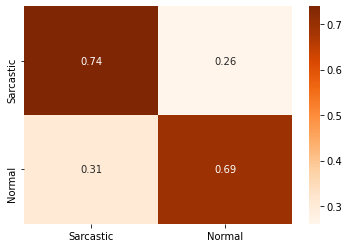

In [28]:
from string import ascii_uppercase
from pandas import DataFrame
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix

confm = confusion_matrix(actuals, preds,normalize='true')

columns = ["Sarcastic","Normal"]


df_cm = DataFrame(confm, index=columns, columns=columns)

ax = sn.heatmap(df_cm, cmap='Oranges', annot=True)

In [ ]:
sum(preds)/len(preds)